In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import string
import math
import gensim.downloader as api

In [3]:
df = pd.read_excel("Dataset.xlsx")
questionList = df["Question"].unique()
answerList = df["Answer"]
# for answer in answerList:
#     print(answer)
print("Answer list : {}".format(len(answerList)))
print("Question list : {}".format(len(questionList)))

df

Answer list : 72
Question list : 11


,No,Question,Answer,Event,Speaker,Q-Label,A-Label
0,1,How did we come to exist?,Everybody should believe that they are creatio...,2022-02-19,P,Sesuai,Sesuai
1,2,How did we come to exist?,"We came from evolution. This is undeniable, an...",2022-02-19,G,Sesuai,Sesuai
2,3,Do you think you need to exist?,We don't really need to exist. Even if I don't...,2022-02-19,P,Sesuai,Sesuai
3,4,Do you think you need to exist?,"I don't think we need to exist. As Peter said,...",2022-02-19,Je,Sesuai,Sesuai
4,5,Do you think you need to exist?,I think we are a part of a bigger picture.,2022-02-19,Th,Sesuai,Tidak Sesuai
...,...,...,...,...,...,...,...
67,68,We see from our side that maybe they are miser...,"Everyone has rights, even fetuses or babies, b...",2023-07-02,Stanley,NaN,NaN
68,69,We see from our side that maybe they are miser...,Is it wrong to regret life? That is the right ...,2023-07-02,Greg,NaN,NaN
69,70,We see from our side that maybe they are miser...,"Actually, we humans are well aware that life i...",2023-07-02,Yotam,NaN,NaN
70,71,We see from our side that maybe they are miser...,The law didn't need to be revised. Choosing th...,2023-07-02,Stanley,NaN,NaN


In [4]:
# get all words
import contractions
word_list = ""
for i in range(len(df)):
    word_list += " {}".format(df["Answer"][i])

word_list = word_list.lower()

word_list = contractions.fix(word_list)
    
# Remove punctuations
word_list = "".join([char for char in word_list if char not in string.punctuation])

word_set = set()
for word in nltk.word_tokenize(word_list):
    word_set.add(word)

# print(word_set)

print(type(nltk.word_tokenize(word_list)))


<class 'list'>


In [5]:
# function for separating per sentences for each document.
def get_sentences(document):
    sentences = document.split(". ")
    return sentences

Preprocess a bit before splitting

In [6]:
import contractions

# returns list of sentences.

def preprocess(document):
    # remove contractions
    document = contractions.fix(document)

    # case fold
    document = document.lower()

    # split to sentencesaa
    sentences = get_sentences(document)

    # turn numbers into spoken phrases

    # remove punctuation
    for i in range(len(sentences)):
        for j in range(len(sentences[i])):
            sentences[i] = "".join([char for char in sentences[i] if char not in string.punctuation])
    return sentences


In [7]:
result = preprocess(df["Answer"][1])

print(result)

['we came from evolution', 'this is undeniable and the charles darwins evolution model is the most widely accepted theory to this', 'we evolved from unicellular bacteriae to fish to amphibious creatures to mammals to apes then all the way to humans']


Spacy for future references

In [8]:
import spacy
from spacy.pipeline import EntityRuler

nlp = spacy.load("en_core_web_sm")
ruler = EntityRuler(nlp)

patterns = [
    {"label": "ABBREVIATION", "pattern": [{"TEXT": {"REGEX": "^[A-Z]{2,}$"}}]}
]

ruler.add_patterns(patterns)

nlp.add_pipe("entity_ruler")
nlp.add_pipe("sentencizer")
nlp.replace_pipe("entity_ruler", ruler)

doc = nlp("NASA is a well-known abbreviation for National Aeronautics and Space Administration.")

for ent in doc.ents:
    if ent.label_ == "ABBREVIATION":
        print(ent.text)

ValueError: [E968] `nlp.replace_pipe` now takes the string name of the registered component factory, not a callable component. Expected string, but got <spacy.pipeline.entityruler.EntityRuler object at 0x000001AAFB8C0580>.

- If you created your component withwith `nlp.create_pipe('name')`: remove `nlp.create_pipe` and call `nlp.replace_pipe('entity_ruler', 'name')` instead.

- If you passed in a component like `TextCategorizer()`: call `nlp.replace_pipe` with the string name instead, e.g. `nlp.replace_pipe('entity_ruler', 'textcat')`.

- If you're using a custom component: Add the decorator `@Language.component` (for function components) or `@Language.factory` (for class components / factories) to your custom component and assign it a name, e.g. `@Language.component('your_name')`. You can then run `nlp.replace_pipe('entity_ruler', 'your_name')`.

Split by question

In [8]:
questionList = df["Question"].unique()
df_by_questions = df.groupby("Question")
questionKeys = list(df_by_questions.groups.keys())

answer_by_questions = {}
for key in questionKeys:
    answer_by_questions[key] = list(df_by_questions.get_group(key)["Answer"])

print(df_by_questions.get_group(questionList[0]))
print(answer_by_questions[questionList[0]])

   No                   Question  \
0   1  How did we come to exist?   
1   2  How did we come to exist?   

                                              Answer      Event Speaker  \
0  Everybody should believe that they are creatio... 2022-02-19       P   
1  We came from evolution. This is undeniable, an... 2022-02-19       G   

  Q-Label A-Label  
0  Sesuai  Sesuai  
1  Sesuai  Sesuai  
['Everybody should believe that they are creations, made by a creator. It is a prerequisite to believing anything else that comes after.', "We came from evolution. This is undeniable, and the Charles Darwin's evolution model is the most widely accepted theory to this. We evolved from unicellular bacteriae, to fish, to amphibious creatures, to mammals, to apes, then all the way to humans."]


Split by events

In [9]:
eventList = df["Event"].unique()
df_by_events = df.groupby("Event")
df_by_events.get_group(eventList[0])

,No,Question,Answer,Event,Speaker,Q-Label,A-Label
0,1,How did we come to exist?,Everybody should believe that they are creatio...,2022-02-19,P,Sesuai,Sesuai
1,2,How did we come to exist?,"We came from evolution. This is undeniable, an...",2022-02-19,G,Sesuai,Sesuai
2,3,Do you think you need to exist?,We don't really need to exist. Even if I don't...,2022-02-19,P,Sesuai,Sesuai
3,4,Do you think you need to exist?,"I don't think we need to exist. As Peter said,...",2022-02-19,Je,Sesuai,Sesuai
4,5,Do you think you need to exist?,I think we are a part of a bigger picture.,2022-02-19,Th,Sesuai,Tidak Sesuai
5,6,Do you think you need to exist?,"Yes, because we're a part of a community where...",2022-02-19,Th,Sesuai,Sesuai
6,7,Do you think you need to exist?,"In general, humans have made many impacts. Th...",2022-02-19,DJ,Sesuai,Sesuai
7,8,Do you think you need to exist?,"This got me thinking, if we question the purpo...",2022-02-19,R,Sesuai,Tidak Sesuai
8,9,"From a bigger perspective, why did God create us?",It's a mystery. We won't know. Religion said s...,2022-02-19,G,Sesuai,Sesuai
9,10,"From a bigger perspective, why did God create us?",I think God himself needs an outlet to His lov...,2022-02-19,Th,Sesuai,Sesuai


For each sentence, embed each word


In [10]:
import gensim
import gensim.downloader as api
from nltk.test.gensim_fixt import setup_module
setup_module()

model = api.load('word2vec-google-news-300')


In [11]:
def sentence_embed(sentence, w2v, aggregate="avg"):
    # get word vectors
    word_vectors = [w2v[word] for word in sentence if word in w2v]
    sentence_vectors = []
    if aggregate == "avg":
        sentence_vectors = sentence_average(word_vectors)
    elif aggregate == "wavg":
        pass
    elif aggregate == "wsum":
        pass
    else:
        print("that's why yo granny ain't got no knees")
    
    return sentence_vectors
    
# normal average
def sentence_average(wvs):
    return np.mean(wvs, axis=0)
    
# weighted average
def weighted_average(wvs, weights):
    weighted_vectors = np.multiply(wvs, weights.reshape(-1, 1))
    return np.mean(weighted_vectors, axis=0)

# weighted sum
def weighted_sum(wvs, weights):
    weighted_vectors = np.multiply(wvs, weights.reshape(-1,1))
    return np.sum(weighted_vectors, axis=0)

def aggregate_sentences(sentence_vectors):
    return np.mean(sentence_vectors, axis=0)
# tfidf perhaps...


# tokenize 
from nltk.corpus import stopwords
def tokenize(sentenceList, isStopwords=False, isLemma=False):
    sentenceTokenList = [nltk.word_tokenize(sentence) for sentence in sentenceList]
    if isStopwords:
        stop_words = set(stopwords.words("english"))
        for i in range(len(sentenceTokenList)):
            sentenceTokenList[i] = [w for w in sentenceTokenList[i] if not w in stop_words]
    if isLemma:

        pass
    return sentenceTokenList
        

In [12]:
for key in answer_by_questions.keys():
    print(key, "____________________________")
    for i in range(len(answer_by_questions[key])):
        answer_by_questions[key][i] = preprocess(answer_by_questions[key][i])    
        print(answer_by_questions[key][i]) 

  

Do you think abortion should be legal? ____________________________
['legal  not really legal  legal for special cases', 'like for sexual assault rape etc', 'but at least 6 months  you can go over the pregnancy period', 'but really it should be all legal because orphanages are still not 100 ideal', 'so it should be from prevention']
['agree with other solutions besides abortion  but if we bring it to indo we are not as advanced as other countries where orphanages are more obvious']
['should be legal with criteria', 'agree with indonesia  just not the first 6 weeks  not sure of size']
['what counts as a person is fetus a person']
['does not being a christian still fall under christian rules']
['if it has a heartbeat can it be called life nowadays there is a fight for animal rights', 'are animals more valuable than humans if it is a life it should be allowed to live', 'i am prolife  no matter how hard life is it has to be lived']
['when something grows does not it count as life already i

In [13]:
for key in answer_by_questions.keys():
    for i in range(len(answer_by_questions[key])):
        # print(tokenize(answer_by_questions[key][i], isStopwords=False))
        # print(answer_by_questions[key][i])
        answer_by_questions[key][i] = tokenize(answer_by_questions[key][i], isStopwords=False)
        
 

In [14]:
for key in answer_by_questions.keys():
    print(key, "====================================")
    for i in range(len(answer_by_questions[key])):
        print(answer_by_questions[key][i])
    print("=========================================")

Do you think abortion should be legal? ====================================
[['legal', 'not', 'really', 'legal', 'legal', 'for', 'special', 'cases'], ['like', 'for', 'sexual', 'assault', 'rape', 'etc'], ['but', 'at', 'least', '6', 'months', 'you', 'can', 'go', 'over', 'the', 'pregnancy', 'period'], ['but', 'really', 'it', 'should', 'be', 'all', 'legal', 'because', 'orphanages', 'are', 'still', 'not', '100', 'ideal'], ['so', 'it', 'should', 'be', 'from', 'prevention']]
[['agree', 'with', 'other', 'solutions', 'besides', 'abortion', 'but', 'if', 'we', 'bring', 'it', 'to', 'indo', 'we', 'are', 'not', 'as', 'advanced', 'as', 'other', 'countries', 'where', 'orphanages', 'are', 'more', 'obvious']]
[['should', 'be', 'legal', 'with', 'criteria'], ['agree', 'with', 'indonesia', 'just', 'not', 'the', 'first', '6', 'weeks', 'not', 'sure', 'of', 'size']]
[['what', 'counts', 'as', 'a', 'person', 'is', 'fetus', 'a', 'person']]
[['does', 'not', 'being', 'a', 'christian', 'still', 'fall', 'under', 'ch

In [15]:
spare_abq = answer_by_questions.copy()

ONLY RUN THIS ONE BELOW IN AN MERGENCY

In [17]:
answer_by_questions = spare_abq.copy()

END!!!!!!!

In [16]:
sentence_embedded = []
sentence_text = []
spare_abq = answer_by_questions.copy()
for key in answer_by_questions.keys():
    for i in range(len(answer_by_questions[key])):
        for j in range(len(answer_by_questions[key][i])):
            if not len(answer_by_questions[key][i][j]) == 0:
                sentence_embedded.append(sentence_embed(answer_by_questions[key][i][j], model))
                answer_by_questions[key][i][j] = sentence_embed(answer_by_questions[key][i][j], model)
                # sentence_text.append(answer_by_questions[key][i][j])
            else:
                print(key, i, j, "this bitch EMPTY!!!!!!!!!!!!!!!!!!!!!!!!", type(answer_by_questions[key][i][j]))
                del answer_by_questions[key][i][j]
                
            
# for key in answer_by_questions.keys():
#     for i in range(len(answer_by_questions[key])):
#         for j in range(len(answer_by_questions[key][i])):
#             print(answer_by_questions[key][i][j])

# answer_by_questions


From a bigger perspective, why did God create us? 3 2 this bitch EMPTY!!!!!!!!!!!!!!!!!!!!!!!! <class 'list'>


In [17]:
# for i in range(len(sentence_text)):
#     print(sentence_text[i])
#     print(sentence_embedded[i])
#     print("_______________________________________")

for key in answer_by_questions.keys():
    for i in range(len(answer_by_questions[key])):
        print(answer_by_questions[key][i])

[array([-6.69326782e-02,  6.00433350e-02, -5.87921143e-02,  8.35418701e-02,
       -2.18658447e-02,  5.14755249e-02,  1.16199493e-01,  2.25524902e-02,
        8.31069946e-02,  4.91027832e-02,  4.35838699e-02, -1.30920410e-02,
       -5.57556152e-02,  3.45001221e-02, -2.40158081e-01,  6.80236816e-02,
        1.70623779e-01,  1.64268494e-01, -2.63404846e-02, -5.36499023e-02,
       -2.13470459e-02, -7.99560547e-03,  1.15905762e-01, -2.41928101e-02,
        2.17895508e-02, -7.07855225e-02, -8.40148926e-02, -3.25164795e-02,
       -4.51278687e-02, -2.42881775e-02,  2.91252136e-02, -5.66177368e-02,
        7.24563599e-02,  8.83178711e-02,  4.90589142e-02, -3.00445557e-02,
        2.93884277e-02,  2.21557617e-02, -2.52437592e-02, -8.56018066e-03,
        1.06662750e-01,  7.21893311e-02,  5.29413223e-02, -4.78057861e-02,
       -1.61574364e-01, -4.40497994e-02,  1.52225494e-02,  5.96313477e-02,
        3.94897461e-02,  5.88684082e-02,  7.95936584e-03, -2.07519531e-03,
       -6.78100586e-02, 

In [18]:
for key in answer_by_questions.keys():
    for i in range(len(answer_by_questions[key])):
        print(answer_by_questions[key][i])

[array([-6.69326782e-02,  6.00433350e-02, -5.87921143e-02,  8.35418701e-02,
       -2.18658447e-02,  5.14755249e-02,  1.16199493e-01,  2.25524902e-02,
        8.31069946e-02,  4.91027832e-02,  4.35838699e-02, -1.30920410e-02,
       -5.57556152e-02,  3.45001221e-02, -2.40158081e-01,  6.80236816e-02,
        1.70623779e-01,  1.64268494e-01, -2.63404846e-02, -5.36499023e-02,
       -2.13470459e-02, -7.99560547e-03,  1.15905762e-01, -2.41928101e-02,
        2.17895508e-02, -7.07855225e-02, -8.40148926e-02, -3.25164795e-02,
       -4.51278687e-02, -2.42881775e-02,  2.91252136e-02, -5.66177368e-02,
        7.24563599e-02,  8.83178711e-02,  4.90589142e-02, -3.00445557e-02,
        2.93884277e-02,  2.21557617e-02, -2.52437592e-02, -8.56018066e-03,
        1.06662750e-01,  7.21893311e-02,  5.29413223e-02, -4.78057861e-02,
       -1.61574364e-01, -4.40497994e-02,  1.52225494e-02,  5.96313477e-02,
        3.94897461e-02,  5.88684082e-02,  7.95936584e-03, -2.07519531e-03,
       -6.78100586e-02, 

In [21]:
# draw it with tSNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plotW2V2(w2v, wordList):
    labels = []
    tokens = []

    # append tokens and labels
    for word in wordList:
        if word in w2v:
            labels.append(word)
            tokens.append(w2v[w2v.key_to_index[word]])

    print(type(tokens))
    print(len(tokens))
    print(type(tokens[0]))
    print(len(tokens[0]))
    
    # train the model
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))

    # plot that thang
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


def plotSentences(sentence_vectors, key, length=40):
    
    labels = np.arange(0, len(sentence_embedded))
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(sentence_vectors))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    plt.title(key)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()



    

<class 'list'>
566
<class 'numpy.ndarray'>
300


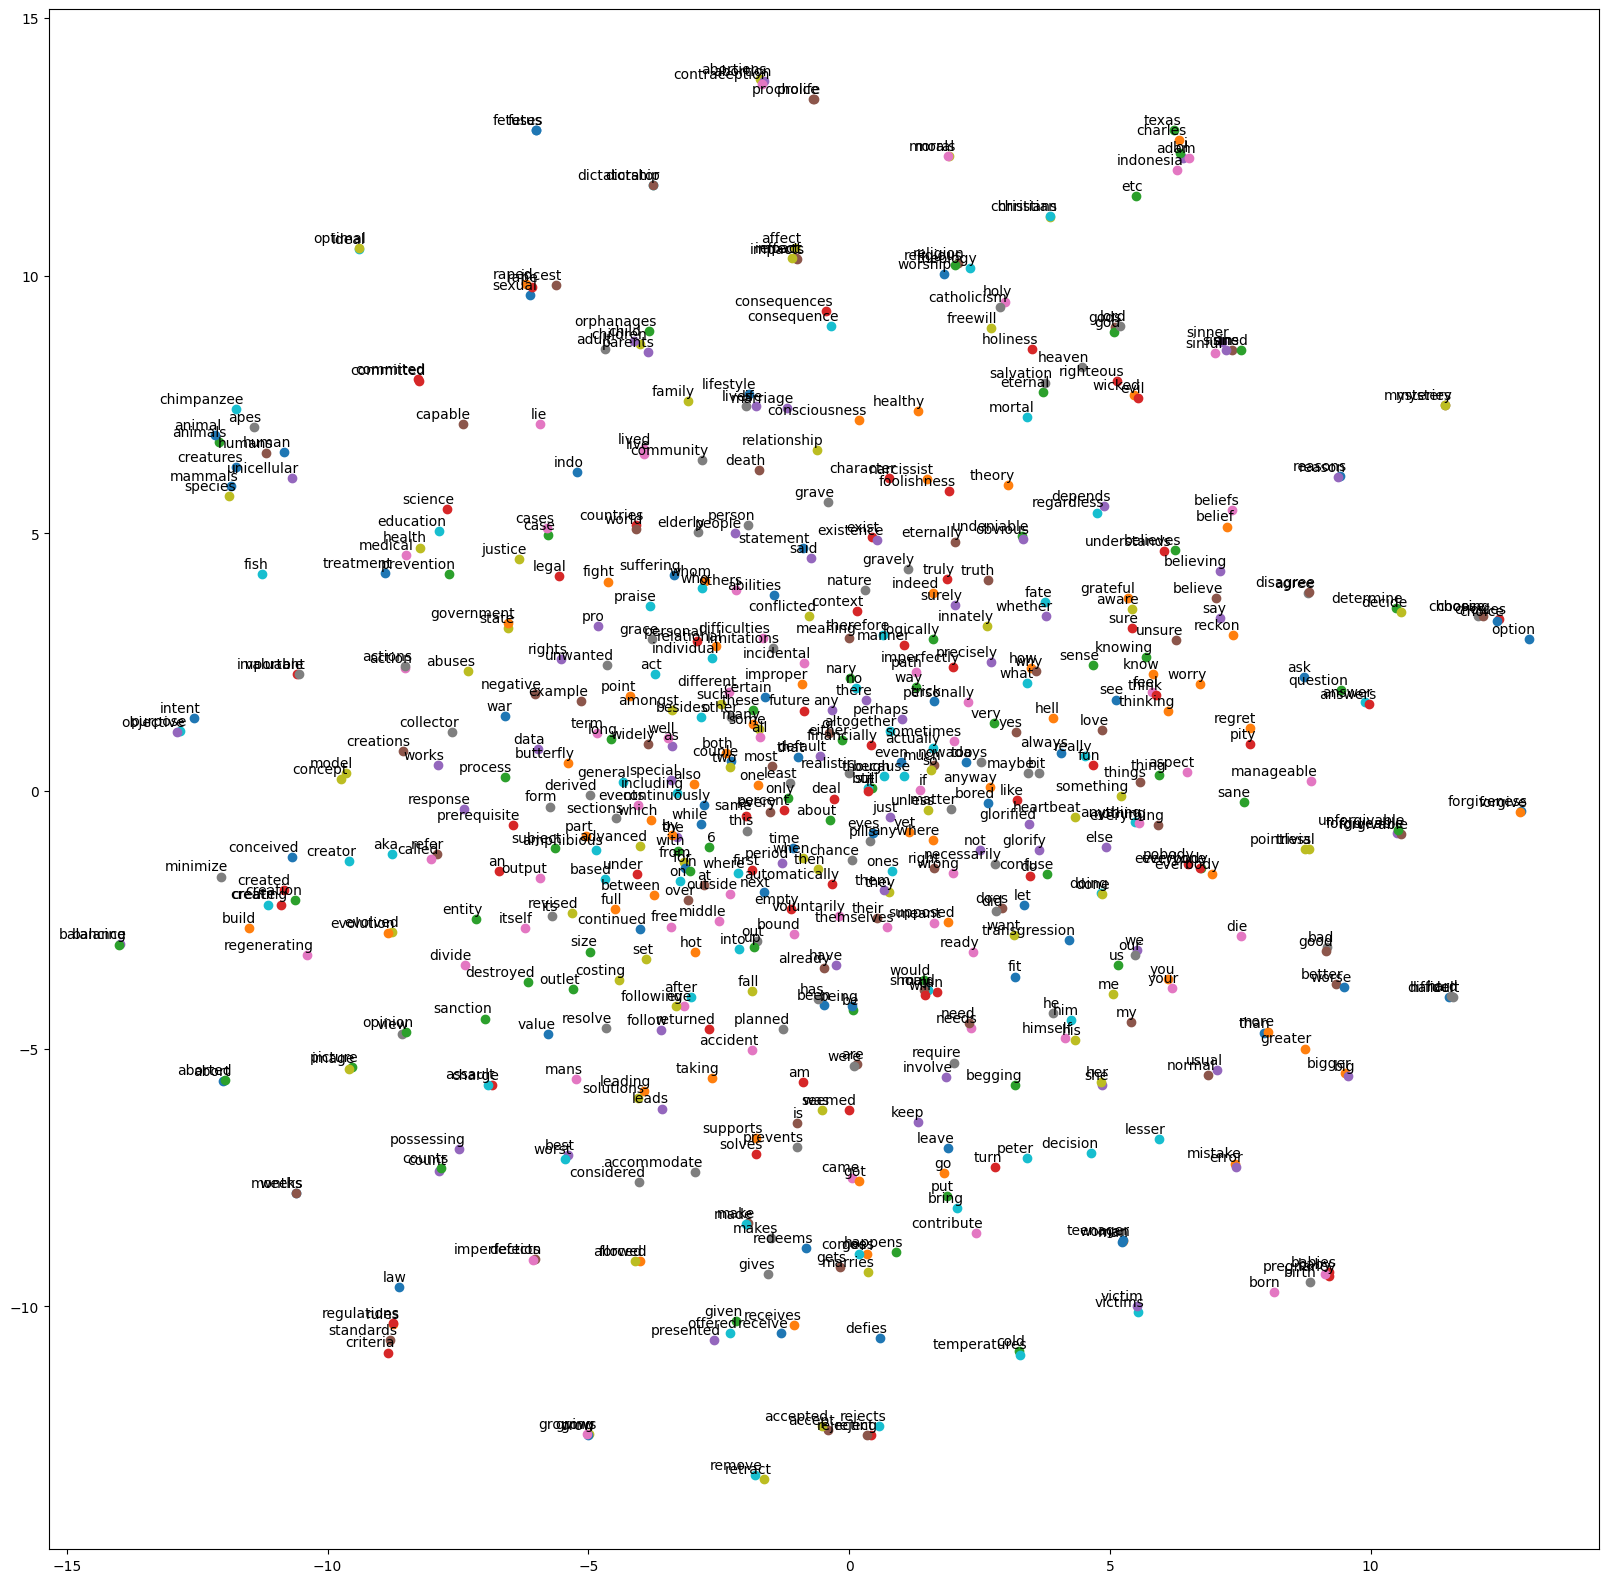

In [22]:
wordList = list(word_set)
plotW2V2(model, wordList)

Verdict: rather accurate word-embedding

In [1]:
sentence_embedded = np.array(sentence_embedded)
plotSentences(sentence_embedded, "uohhhhh my ghoddddd")

NameError: name 'np' is not defined

In [25]:
# per question

for key in answer_by_questions.keys():
    for i in range(len(answer_by_questions[key])):
        answer_by_questions[key][i] = aggregate_sentences(answer_by_questions[key][i])

In [26]:
for key in answer_by_questions.keys():
    plotSentences(answer_by_questions[key], key, len(answer_by_questions[key]) - 1)

ValueError: perplexity must be less than n_samples

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the documents in the corpus
documents = [
    "This is the first document.",
    "This is the second document.",
    "And this is the third document."
]

# Compute the TF-IDF matrix
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(documents)

# Print the matrix
print(matrix.toarray())

[[0.         0.38161415 0.64612892 0.38161415 0.         0.38161415
  0.         0.38161415]
 [0.         0.38161415 0.         0.38161415 0.64612892 0.38161415
  0.         0.38161415]
 [0.54270061 0.32052772 0.         0.32052772 0.         0.32052772
  0.54270061 0.32052772]]


[-1 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0 -1  0  0
  0  0  0  0 -1  0 -1  0  0  0  0  0  0 -1  0  0  1  0  0  0  0  0 -1  0
  0  0  1  0  0  0  0  0  0  0  2  0 -1 -1  0  0  0  0  0  2  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1 -1  0  0  0 -1 -1  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0 -1
  0  0  0  0  0  0  0 -1  0 -1  0  0  0 -1  0 -1  0  0  0  0  0  0  0 -1
  0  0  0  0  0]


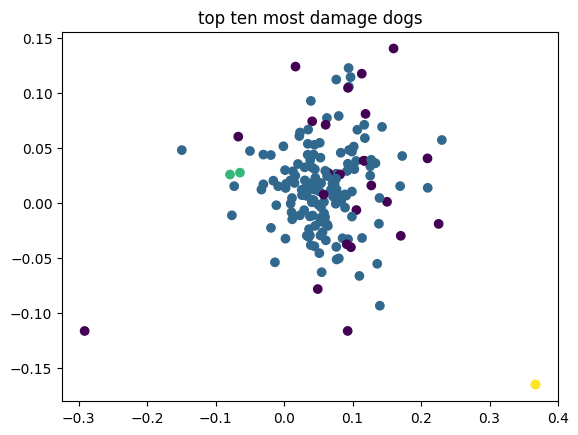

In [311]:
#clustering

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, normalized_mutual_info_score

def dbscan_draw(vectors, titles):
    dbscan = DBSCAN(eps=1, min_samples=2)
    clusters = dbscan.fit_predict(vectors)
    print(clusters)
    # plt.title(titles)
    # plt.scatter(vectors[:, 0], vectors[:, 1], c=clusters)
    # plt.show()

    

dbscan = DBSCAN(eps=1, min_samples=2)

clusters = dbscan.fit_predict(sentence_embedded)
print(clusters)

# you can try
plt.title("top ten most damage dogs")
plt.scatter(sentence_embedded[:, 0], sentence_embedded[:, 1], c=clusters)
plt.show()

In [300]:
print(len(sentence_embedded))
print(len(sentence_embedded[0]))


173
300


In [313]:
# print allat.

for key in answer_by_questions.keys():
    dbscan_draw(answer_by_questions[key], key)


[0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0]
[0 0 0 0]
[ 0  0 -1  0  0  0  0]
[0 0]
[0 0 0 0]
[0 0 0 1 0 1]
[0 0 0 0 0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
[0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0]


Reproducing the steps upstairs. But this time with a structured data

In [93]:
# take data per group
allat = aggregate_sentences(sentence_embedded)

In [95]:
# make it happen
print(allat)

[ 0.06136246  0.01263753  0.0687516   0.10223775 -0.0873887   0.03589462
  0.08954713 -0.06222522  0.06952357  0.06120421 -0.0656059  -0.1213157
 -0.03396369  0.02983547 -0.09354623  0.10810097  0.05223755  0.09023687
  0.00344375 -0.04787569 -0.01246391  0.01712279  0.04711396 -0.00910256
  0.05443588 -0.02645693 -0.08406451  0.05496659  0.02464671 -0.01435559
 -0.01027716  0.01420085 -0.04877595  0.02867831  0.03253054  0.02036862
  0.02859753  0.00089472  0.03725509  0.03905041  0.10426576  0.00383414
  0.11290284 -0.02902911 -0.01426307 -0.0333415   0.00068513  0.02981944
 -0.00469331 -0.01937883  0.0002658   0.04262893 -0.02386948 -0.01885252
  0.03187196  0.0439459  -0.03314309 -0.05443208  0.02757946 -0.04487302
  0.02058449  0.1019098  -0.0565661  -0.06720727 -0.01602248 -0.02407207
 -0.02666457  0.10509238 -0.07935312  0.05544934  0.05933234  0.03968832
  0.05838706  0.01065048 -0.10204473 -0.06825081  0.08007868  0.08821796
  0.03867571  0.12559904  0.00754811 -0.05636054  0.

In [ ]:
# die in obscurity.

In [253]:
# present the results  

mystrings = ["the",
             "mind",
             "death",
             "of",
             "mind",
             "mind"]

print(mystrings)

del mystrings[4]

print(mystrings)

['the', 'mind', 'death', 'of', 'mind', 'mind']
['the', 'mind', 'death', 'of', 'mind']
